# 06 — Stance Analysis: “End the War” vs “Fight Until Victory”

This notebook adds a stance analysis layer to the project.

Goal:
- Estimate whether comments are more aligned with **ending the war soon (negotiation/ceasefire)** or **continuing until Ukraine regains territory (victory/aid/military support)**.

Approach:
1. Extract stance keyword/phrase candidates from **topic outputs** and **comment n-grams** (data-driven).
2. Build a transparent stance lexicon (editable).
3. Apply stance classification to event datasets.
4. Aggregate results by event and by **U.S.-focused vs non–U.S.-focused** subreddits.


In [2]:
import os
import re
import json
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer


In [4]:

BASE_EVENTS_DIR = "../data/processed"
BASE_TOPICS_DIR = "../data/processed/topics"
OUT_DIR = "../data/processed/stance"

os.makedirs(OUT_DIR, exist_ok=True)

event_files = {
    "event1_kyiv": os.path.join(BASE_EVENTS_DIR, "event1_kyiv.csv"),
    "event2_kherson": os.path.join(BASE_EVENTS_DIR, "event2_kherson.csv"),
    "event3_stalemate": os.path.join(BASE_EVENTS_DIR, "event3_stalemate.csv"),
    "event4_trump_election": os.path.join(BASE_EVENTS_DIR, "event4_trump_election.csv"),
    "event5_white_house_meeting": os.path.join(BASE_EVENTS_DIR, "event5_white_house_meeting.csv"),
}

topic_files = {
    "event1_kyiv": os.path.join(BASE_TOPICS_DIR, "event1_kyiv_topics.csv"),
    "event2_kherson": os.path.join(BASE_TOPICS_DIR, "event2_kherson_topics.csv"),
    "event3_stalemate": os.path.join(BASE_TOPICS_DIR, "event3_stalemate_topics.csv"),
    "event4_trump_election": os.path.join(BASE_TOPICS_DIR, "event4_trump_election_topics.csv"),
    "event5_white_house_meeting": os.path.join(BASE_TOPICS_DIR, "event5_white_house_meeting_topics.csv"),
}

print("Missing event files:")
print([k for k, v in event_files.items() if not os.path.exists(v)])

print("\nMissing topic files:")
print([k for k, v in topic_files.items() if not os.path.exists(v)])


Missing event files:
[]

Missing topic files:
[]


## Step 1 — Candidate stance keywords from LDA topics

We extract keywords from each event’s topic model results.
These are data-driven (they come from the actual Reddit comment corpus).


In [7]:
def parse_topic_words(s):
    # top_words stored like "word1, word2, word3..."
    if pd.isna(s):
        return []
    return [w.strip() for w in str(s).split(",") if w.strip()]

topic_terms = []

for event, path in topic_files.items():
    if not os.path.exists(path):
        continue
    tdf = pd.read_csv(path)
    for _, row in tdf.iterrows():
        words = parse_topic_words(row["top_words"])
        for w in words:
            topic_terms.append({"event": event, "topic_id": row["topic_id"], "term": w})

topic_terms_df = pd.DataFrame(topic_terms)
topic_terms_df.head(), topic_terms_df["term"].nunique()


(         event  topic_id      term
 0  event1_kyiv         0      used
 1  event1_kyiv         0       use
 2  event1_kyiv         0   weapons
 3  event1_kyiv         0  children
 4  event1_kyiv         0      look,
 123)

In [9]:
stance_seeds = [
    "peace", "deal", "cease", "negoti", "talk", "settle", "end",
    "aid", "money", "fund", "weapon", "support", "nato",
    "victory", "territor", "land", "liberat", "annex", "defeat"
]

def seed_match(term):
    t = term.lower()
    return any(seed in t for seed in stance_seeds)

candidates_from_topics = (
    topic_terms_df[topic_terms_df["term"].apply(seed_match)]
    .drop_duplicates()
    .sort_values(["event", "topic_id", "term"])
)

out_path = os.path.join(OUT_DIR, "stance_keywords_candidates_from_topics.csv")
candidates_from_topics.to_csv(out_path, index=False)
print("Saved:", out_path)

candidates_from_topics.head(30)


Saved: ../data/processed/stance/stance_keywords_candidates_from_topics.csv


,event,topic_id,term
2,event1_kyiv,0,weapons
49,event1_kyiv,4,nato
102,event3_stalemate,0,deal
110,event3_stalemate,1,money
126,event3_stalemate,2,nato
159,event4_trump_election,0,money
196,event4_trump_election,4,nato
191,event4_trump_election,4,support
192,event4_trump_election,4,weapons
218,event5_white_house_meeting,1,money


## Step 2 — Candidate stance phrases from comments (n-grams)

Stance is often expressed in phrases (e.g., "peace deal", "stop sending money", "fight until victory").
We mine common 2–3 word phrases from comments for each event, restricted to phrases containing stance seeds.

To keep runtime reasonable, we sample a maximum number of comments per event.


In [12]:
def load_event_text_sample(path, text_col="self_text", max_rows=20000):
    df = pd.read_csv(path, usecols=[text_col, "subreddit"], low_memory=False)
    df = df.dropna(subset=[text_col])
    df[text_col] = df[text_col].astype(str).str.lower()
    df = df[df[text_col].str.len() > 30]
    if len(df) > max_rows:
        df = df.sample(max_rows, random_state=42)
    return df[text_col].tolist()

len(load_event_text_sample(event_files["event4_trump_election"]))


20000

In [14]:
def extract_ngrams(texts, ngram_range=(2,3), min_df=10, max_features=20000):
    vec = CountVectorizer(
        stop_words="english",
        ngram_range=ngram_range,
        min_df=min_df,
        max_features=max_features
    )
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    df = pd.DataFrame({"ngram": terms, "count": freqs}).sort_values("count", ascending=False)
    return df

def contains_seed_phrase(phrase):
    p = phrase.lower()
    return any(seed in p for seed in stance_seeds)

ngram_rows = []

for event, path in event_files.items():
    if not os.path.exists(path):
        continue

    print("Mining ngrams for:", event)
    texts = load_event_text_sample(path, max_rows=20000)

    # Keep min_df lower for smaller events
    min_df = 5 if event in ["event1_kyiv", "event2_kherson"] else 20
    ngrams_df = extract_ngrams(texts, ngram_range=(2,3), min_df=min_df)

    ngrams_df = ngrams_df[ngrams_df["ngram"].apply(contains_seed_phrase)].head(80)
    ngrams_df["event"] = event

    ngram_rows.append(ngrams_df)

ngrams_all = pd.concat(ngram_rows, ignore_index=True)
out_path = os.path.join(OUT_DIR, "stance_phrase_candidates_from_ngrams.csv")
ngrams_all.to_csv(out_path, index=False)
print("Saved:", out_path)

ngrams_all.head(30)


Mining ngrams for: event1_kyiv
Mining ngrams for: event2_kherson
Mining ngrams for: event3_stalemate
Mining ngrams for: event4_trump_election
Mining ngrams for: event5_white_house_meeting
Saved: ../data/processed/stance/stance_phrase_candidates_from_ngrams.csv


,ngram,count,event
0,medical legal aid,25,event1_kyiv
1,legal aid,25,event1_kyiv
2,legal aid polish,25,event1_kyiv
3,passport visas suspended,25,event1_kyiv
4,aid polish government,25,event1_kyiv
5,aid polish,25,event1_kyiv
6,suspended don need,25,event1_kyiv
7,suspended don,25,event1_kyiv
8,visas suspended don,25,event1_kyiv
9,visas suspended,25,event1_kyiv


## Stance Definition (Human-in-the-Loop)

Based on high-frequency n-grams extracted from Reddit comments, stance categories
were defined manually to ensure interpretability and avoid automated bias.

The following three stance categories are used:

1. Pro-Support / Escalation  
   Comments advocating continued or increased military, financial, or political
   support for Ukraine.

2. Pro-Negotiation / End-War  
   Comments emphasizing peace talks, negotiations, or ending the war.

3. Anti-Support / Skeptical  
   Comments opposing aid to Ukraine, supporting Russia, or questioning involvement.

Neutral or contextual phrases (e.g., weapon mentions without stance framing) are excluded.


In [17]:
STANCE_KEYWORDS = {
    "pro_support": [
        "support ukraine", "supporting ukraine", "aid ukraine", "military aid",
        "weapons ukraine", "send troops", "join nato", "nato membership",
        "military support", "defense spending", "long range weapons"
    ],
    "pro_peace": [
        "end war", "war end", "ending war", "peace deal", "peace talks",
        "peace agreement", "make deal", "deal ukraine", "deal russia", "want peace"
    ],
    "anti_support": [
        "support russia", "nato russia", "military spending",
        "trump said"
    ]
}


## Step 3 — Build a stance lexicon

We now create two dictionaries:
- **end_war / negotiation framing**
- **continue_fighting / victory framing**

This lexicon is designed to be transparent and easy to edit.


In [20]:
stance_lexicon = {
    "end_war": [
        r"\bpeace deal\b",
        r"\bpeace talks\b",
        r"\bceasefire\b",
        r"\bnegotiat(e|ion|ions|ing)\b",
        r"\bend the war\b",
        r"\bstop the war\b",
        r"\btime for peace\b",
        r"\bsettlement\b",
        r"\bcompromise\b",
        r"\bstop sending money\b",
        r"\bno more aid\b",
        r"\bwar fatigue\b",
    ],
    "continue_fighting": [
        r"\bfight until\b",
        r"\buntil victory\b",
        r"\bfull victory\b",
        r"\btake back\b",
        r"\bregain\b.*\bterritor(y|ies)\b",
        r"\bliberat(e|ion|ed)\b",
        r"\bdefeat russia\b",
        r"\brussia must lose\b",
        r"\bsend (more )?weapons\b",
        r"\bmilitary aid\b",
        r"\bsupport ukraine\b",
    ]
}

lexicon_path = os.path.join(OUT_DIR, "stance_lexicon_final.json")
with open(lexicon_path, "w") as f:
    json.dump(stance_lexicon, f, indent=2)

print("Saved lexicon to:", lexicon_path)
stance_lexicon


Saved lexicon to: ../data/processed/stance/stance_lexicon_final.json


{'end_war': ['\\bpeace deal\\b',
  '\\bpeace talks\\b',
  '\\bceasefire\\b',
  '\\bnegotiat(e|ion|ions|ing)\\b',
  '\\bend the war\\b',
  '\\bstop the war\\b',
  '\\btime for peace\\b',
  '\\bsettlement\\b',
  '\\bcompromise\\b',
  '\\bstop sending money\\b',
  '\\bno more aid\\b',
  '\\bwar fatigue\\b'],
 'continue_fighting': ['\\bfight until\\b',
  '\\buntil victory\\b',
  '\\bfull victory\\b',
  '\\btake back\\b',
  '\\bregain\\b.*\\bterritor(y|ies)\\b',
  '\\bliberat(e|ion|ed)\\b',
  '\\bdefeat russia\\b',
  '\\brussia must lose\\b',
  '\\bsend (more )?weapons\\b',
  '\\bmilitary aid\\b',
  '\\bsupport ukraine\\b']}

## Step 4 — Apply stance classification to event datasets

We classify each comment as:
- end_war
- continue_fighting
- neutral_or_unclear

Because some event files are very large, we process in chunks.


In [23]:
def stance_label(text, lexicon):
    if not isinstance(text, str):
        return "neutral_or_unclear"

    t = text.lower()

    end_hits = sum(bool(re.search(pat, t)) for pat in lexicon["end_war"])
    cont_hits = sum(bool(re.search(pat, t)) for pat in lexicon["continue_fighting"])

    if end_hits == 0 and cont_hits == 0:
        return "neutral_or_unclear"
    if end_hits > cont_hits:
        return "end_war"
    if cont_hits > end_hits:
        return "continue_fighting"
    return "neutral_or_unclear"  # tie -> neutral


In [25]:
us_focused_subreddits = {
    "politics",
    "Conservative",
    "neoliberal",
    "WayOfTheBern",
    "AskReddit",
    "news",
    "worldnews",
    "geopolitics",
}


In [27]:
results_event = []
results_us_split = []

TEXT_COL = "self_text"

for event, path in event_files.items():
    if not os.path.exists(path):
        continue

    print("Processing:", event)

    # chunked read for big files
    stance_counts = {"end_war": 0, "continue_fighting": 0, "neutral_or_unclear": 0}
    stance_counts_us = {True: {"end_war": 0, "continue_fighting": 0, "neutral_or_unclear": 0},
                        False: {"end_war": 0, "continue_fighting": 0, "neutral_or_unclear": 0}}

    chunk_iter = pd.read_csv(path, low_memory=False, chunksize=200000)

    for chunk in chunk_iter:
        if TEXT_COL not in chunk.columns or "subreddit" not in chunk.columns:
            continue

        chunk = chunk.dropna(subset=[TEXT_COL])
        chunk[TEXT_COL] = chunk[TEXT_COL].astype(str)

        chunk["stance"] = chunk[TEXT_COL].apply(lambda x: stance_label(x, stance_lexicon))
        chunk["is_us_focused"] = chunk["subreddit"].isin(us_focused_subreddits)

        # Event total
        vc = chunk["stance"].value_counts()
        for k in stance_counts.keys():
            stance_counts[k] += int(vc.get(k, 0))

        # US split
        for flag in [True, False]:
            sub = chunk[chunk["is_us_focused"] == flag]
            vc2 = sub["stance"].value_counts()
            for k in stance_counts_us[flag].keys():
                stance_counts_us[flag][k] += int(vc2.get(k, 0))

    total = sum(stance_counts.values())
    results_event.append({
        "event": event,
        "n_comments": total,
        "pct_end_war": stance_counts["end_war"] / total if total else np.nan,
        "pct_continue_fighting": stance_counts["continue_fighting"] / total if total else np.nan,
        "pct_neutral": stance_counts["neutral_or_unclear"] / total if total else np.nan,
    })

    for flag in [True, False]:
        total2 = sum(stance_counts_us[flag].values())
        results_us_split.append({
            "event": event,
            "is_us_focused": flag,
            "n_comments": total2,
            "pct_end_war": stance_counts_us[flag]["end_war"] / total2 if total2 else np.nan,
            "pct_continue_fighting": stance_counts_us[flag]["continue_fighting"] / total2 if total2 else np.nan,
            "pct_neutral": stance_counts_us[flag]["neutral_or_unclear"] / total2 if total2 else np.nan,
        })

event_stance_df = pd.DataFrame(results_event)
us_split_df = pd.DataFrame(results_us_split)

event_out = os.path.join(OUT_DIR, "event_stance_distribution.csv")
split_out = os.path.join(OUT_DIR, "event_stance_us_vs_nonus.csv")

event_stance_df.to_csv(event_out, index=False)
us_split_df.to_csv(split_out, index=False)

print("Saved:", event_out)
print("Saved:", split_out)

event_stance_df


Processing: event1_kyiv
Processing: event2_kherson
Processing: event3_stalemate
Processing: event4_trump_election
Processing: event5_white_house_meeting
Saved: ../data/processed/stance/event_stance_distribution.csv
Saved: ../data/processed/stance/event_stance_us_vs_nonus.csv


,event,n_comments,pct_end_war,pct_continue_fighting,pct_neutral
0,event1_kyiv,2940,0.003401,0.003401,0.993197
1,event2_kherson,795,0.002516,0.000000,0.997484
2,event3_stalemate,9955,0.007032,0.004018,0.988950
3,event4_trump_election,359088,0.012426,0.005481,0.982094
4,event5_white_house_meeting,241262,0.023091,0.006810,0.970099


## Step 5 — Visualize stance across events

We plot:
- % end war
- % continue fighting
- % neutral

This is the main stance result for the report and slides.


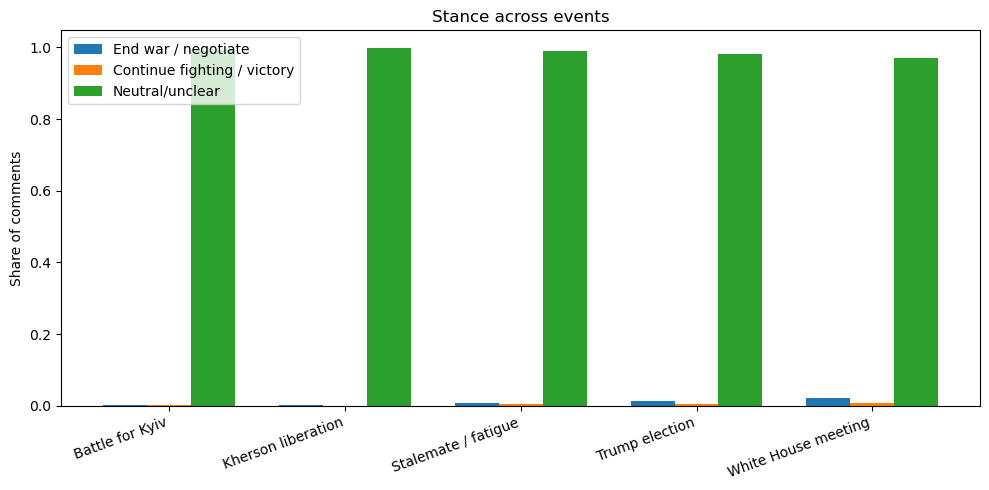

In [30]:
import matplotlib.pyplot as plt

plot_df = event_stance_df.copy()

# If you already have event_labels/order in earlier notebooks, you can paste them here too:
event_labels = {
    "event1_kyiv": "Battle for Kyiv",
    "event2_kherson": "Kherson liberation",
    "event3_stalemate": "Stalemate / fatigue",
    "event4_trump_election": "Trump election",
    "event5_white_house_meeting": "White House meeting",
}
order = ["event1_kyiv","event2_kherson","event3_stalemate","event4_trump_election","event5_white_house_meeting"]

plot_df["event_label"] = plot_df["event"].map(event_labels)
plot_df["event"] = pd.Categorical(plot_df["event"], categories=order, ordered=True)
plot_df = plot_df.sort_values("event")

x = np.arange(len(plot_df))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, plot_df["pct_end_war"], width, label="End war / negotiate")
plt.bar(x, plot_df["pct_continue_fighting"], width, label="Continue fighting / victory")
plt.bar(x + width, plot_df["pct_neutral"], width, label="Neutral/unclear")
plt.xticks(x, plot_df["event_label"], rotation=20, ha="right")
plt.ylabel("Share of comments")
plt.title("Stance across events")
plt.legend()
plt.tight_layout()
plt.show()


## Step 6 — Conditional Stance Analysis (Fixing the “Neutral Dilution” Problem)

When we first computed stance percentages, most comments were labeled **neutral**.  
This does *not* mean people had no opinion — it mainly means that most Reddit comments do not explicitly say phrases like:

- “end the war”
- “peace deal”
- “support Ukraine”
- “send troops”

Instead, many comments are short reactions, jokes, emotional responses, or discussions that do not directly express a clear policy stance.

### Why we use conditional stance analysis
To make stance results more meaningful, we calculate stance percentages **only among stance-bearing comments**.  
This answers a stronger question:

> **When people *do* express an explicit stance, which stance is more common?**

This approach is more interpretable and prevents the results from being dominated by neutral comments.


### Build stance-only dataset and compute conditional stance per event

This code does three things:

1. **Filters out neutral comments**, keeping only comments labeled as:
   - `end_war`
   - `continue_fighting`

2. **Counts stance comments per event**, grouped by stance category.

3. **Normalizes the counts within each event**, so results are percentages that sum to 100% per event (within stance-bearing comments).

Output:
- A table showing stance balance for each event, conditional on stance expression.


In [42]:
# Conditional stance (event-level)
# Among stance-bearing comments only: end_war vs continue_fighting
event_conditional_df = event_stance_df.copy()

stance_total = event_conditional_df["pct_end_war"] + event_conditional_df["pct_continue_fighting"]

event_conditional_df["pct_end_war_conditional"] = event_conditional_df["pct_end_war"] / stance_total
event_conditional_df["pct_continue_fighting_conditional"] = event_conditional_df["pct_continue_fighting"] / stance_total

event_conditional_df[["event", "n_comments", "pct_end_war_conditional", "pct_continue_fighting_conditional"]]



,event,n_comments,pct_end_war_conditional,pct_continue_fighting_conditional
0,event1_kyiv,2940,0.500000,0.500000
1,event2_kherson,795,1.000000,0.000000
2,event3_stalemate,9955,0.636364,0.363636
3,event4_trump_election,359088,0.693935,0.306065
4,event5_white_house_meeting,241262,0.772248,0.227752


### Conditional stance split: U.S.-focused vs non–U.S.-focused subreddits

Our project question is mainly about U.S. public opinion and how it may shift with U.S. political changes.

So in this step we repeat the conditional stance calculation, but we split the data into:

- **U.S.-focused subreddits** (`is_us_focused = True`)
- **non–U.S.-focused subreddits** (`is_us_focused = False`)

This helps us compare whether stance shifts are stronger in U.S.-politics communities versus international or global communities.

Output:
- A table showing, for each event and subreddit group, the percentage of stance-bearing comments that support:
  - `end_war`
  - `continue_fighting`


In [44]:
# Conditional stance split (U.S. vs non-U.S.)
us_conditional_df = us_split_df.copy()

stance_total = us_conditional_df["pct_end_war"] + us_conditional_df["pct_continue_fighting"]

us_conditional_df["pct_end_war_conditional"] = us_conditional_df["pct_end_war"] / stance_total
us_conditional_df["pct_continue_fighting_conditional"] = us_conditional_df["pct_continue_fighting"] / stance_total

us_conditional_df[["event", "is_us_focused", "n_comments", "pct_end_war_conditional", "pct_continue_fighting_conditional"]]


,event,is_us_focused,n_comments,pct_end_war_conditional,pct_continue_fighting_conditional
0,event1_kyiv,True,0,NaN,NaN
1,event1_kyiv,False,2940,0.500000,0.500000
2,event2_kherson,True,0,NaN,NaN
3,event2_kherson,False,795,1.000000,0.000000
4,event3_stalemate,True,0,NaN,NaN
5,event3_stalemate,False,9955,0.636364,0.363636
6,event4_trump_election,True,94394,0.726705,0.273295
7,event4_trump_election,False,264694,0.678243,0.321757
8,event5_white_house_meeting,True,78480,0.814644,0.185356
9,event5_white_house_meeting,False,162782,0.748430,0.251570


### Conditional stance distribution across events


Each event shows the share of stance-bearing comments that fall into:

- `end_war` (negotiation / ending the war)
- `continue_fighting` (continued support / victory framing)

Why this plot matters:
- It removes neutral noise
- It provides a clear “stance balance” view across time
- It makes event-to-event comparisons easier for the report and slides


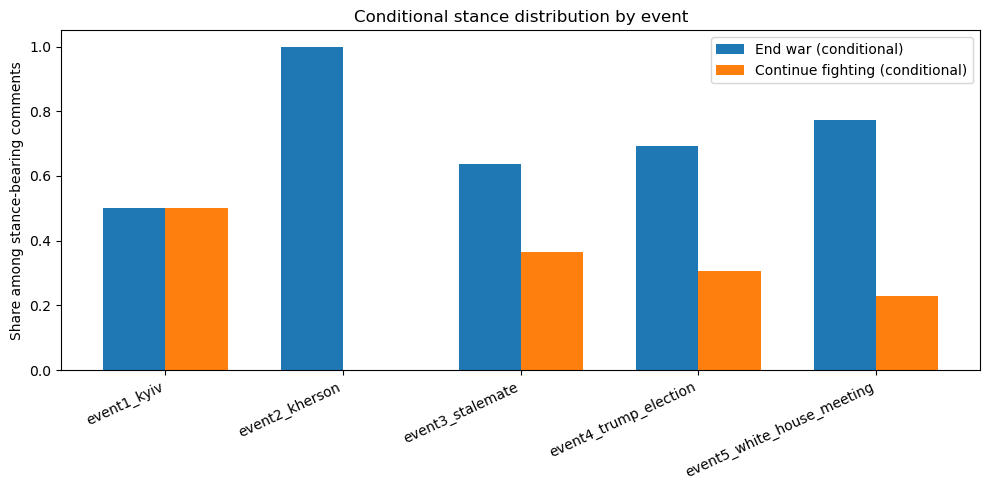

In [48]:
import matplotlib.pyplot as plt


plot_df = event_conditional_df.copy()

x = np.arange(len(plot_df))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, plot_df["pct_end_war_conditional"], width, label="End war (conditional)")
plt.bar(x + width/2, plot_df["pct_continue_fighting_conditional"], width, label="Continue fighting (conditional)")

plt.xticks(x, plot_df["event"], rotation=25, ha="right")
plt.ylabel("Share among stance-bearing comments")
plt.title("Conditional stance distribution by event")
plt.legend()
plt.tight_layout()
plt.show()


### Plot: Conditional stance comparison (U.S.-focused vs non–U.S.-focused)



It shows the conditional stance distribution **separately for:**
- U.S.-focused subreddits
- non–U.S.-focused subreddits

Why this plot matters:
- It directly supports the main goal of this project:
  **Does U.S. public stance shift in a way that mirrors U.S. political shifts?**
- It also provides a useful comparison baseline with international communities.


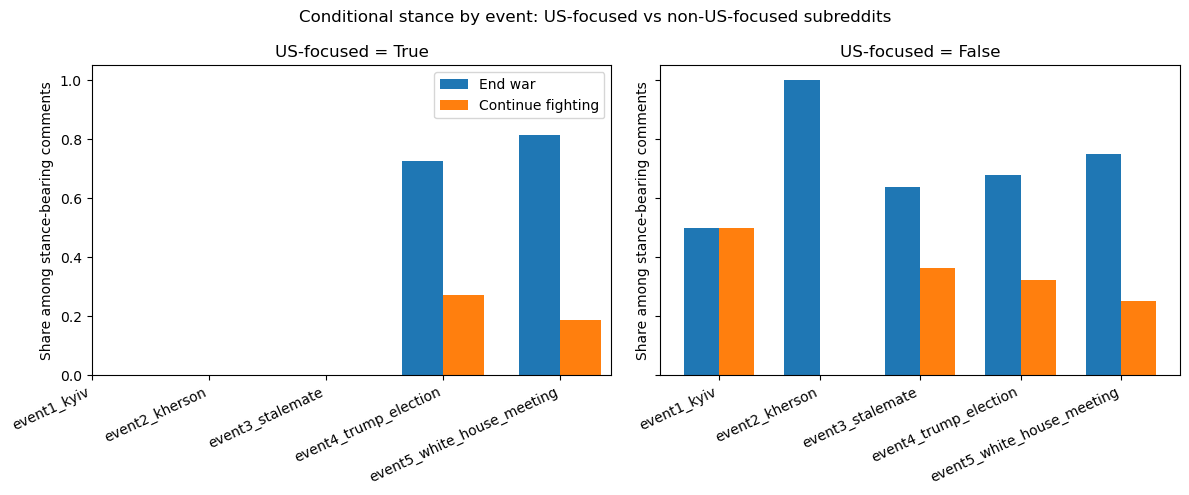

In [50]:


# Ensure stable ordering of events
event_order = list(event_conditional_df["event"])
us_plot = us_conditional_df.copy()
us_plot["event"] = pd.Categorical(us_plot["event"], categories=event_order, ordered=True)
us_plot = us_plot.sort_values(["is_us_focused", "event"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, flag in zip(axes, [True, False]):
    sub = us_plot[us_plot["is_us_focused"] == flag]

    x = np.arange(len(sub))
    width = 0.35

    ax.bar(x - width/2, sub["pct_end_war_conditional"], width, label="End war")
    ax.bar(x + width/2, sub["pct_continue_fighting_conditional"], width, label="Continue fighting")

    ax.set_xticks(x)
    ax.set_xticklabels(sub["event"], rotation=25, ha="right")
    ax.set_title(f"US-focused = {flag}")
    ax.set_ylabel("Share among stance-bearing comments")

axes[0].legend()
plt.suptitle("Conditional stance by event: US-focused vs non-US-focused subreddits")
plt.tight_layout()
plt.show()


##  Stance Index (One-number trend summary)

To summarize stance balance with a single number, we define:

**stance_index = (continue_fighting %) − (end_war %)**

Interpretation:
- **Positive value** → more “continue fighting” framing
- **Negative value** → more “end war / negotiation” framing
- **Closer to 0** → stance is more balanced

This metric is helpful for a simple event-to-event trend plot and can be used in presentation slides as a single headline indicator.


In [52]:
event_conditional_df["stance_index"] = (
    event_conditional_df["pct_continue_fighting_conditional"]
    - event_conditional_df["pct_end_war_conditional"]
)

event_conditional_df[["event", "stance_index"]]


,event,stance_index
0,event1_kyiv,0.000000
1,event2_kherson,-1.000000
2,event3_stalemate,-0.272727
3,event4_trump_election,-0.387869
4,event5_white_house_meeting,-0.544497
